In [37]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [24]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()
data = pd.read_parquet(Path("data") / "train.parquet").drop('bike_count', axis=1)

In [4]:
from sklearn.preprocessing import FunctionTransformer

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

date_encoder = FunctionTransformer(_encode_dates, validate=False)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001AAAC31FEC0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [6]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):}"
)

Train set, RMSE=0.8007500730068353
Test set, RMSE=0.725305954393917


In [27]:
X_train.shape

(455163, 9)

import ydata_profiling
data.profile_report() 

In [155]:
from sklearn.preprocessing import StandardScaler 

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
date_cols.remove("year")

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name"]

# num_encoder = StandardScaler()
# num_cols = ["longitude", "latitude"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        # ("nothing", num_encoder, num_cols)
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False)}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"
)

Train set, RMSE=0.8007500862216808
Test set, RMSE=0.7245163396070868


In [78]:
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
date_cols.remove("year")
date_cols

['month', 'day', 'weekday', 'hour']

In [46]:
from sklearn.linear_model import Lasso
regressor = Lasso()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False)}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"
)

Train set, RMSE=1.6750574303640235
Test set, RMSE=1.4874923363403572


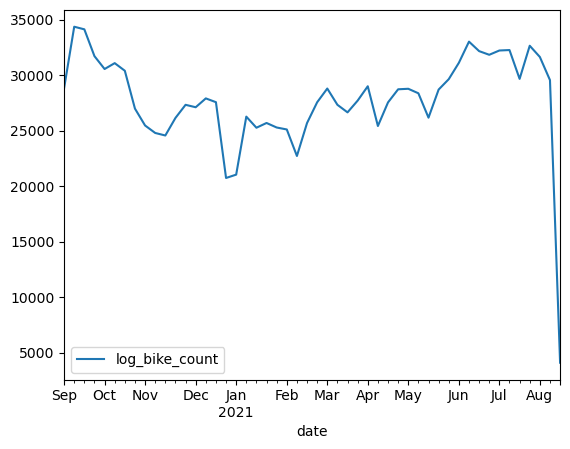

In [82]:
data.groupby(pd.Grouper(freq="1w", key="date"))[["log_bike_count"]].sum().plot()
plt.show()

In [58]:
df_work = data.copy().drop(columns=["counter_id", "site_id", "counter_technical_id"])
df_work=_encode_dates(df_work)
df_work.tail()

,counter_name,site_name,counter_installation_date,latitude,longitude,log_bike_count,year,month,day,weekday,hour
928450,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2020-11-29,48.83977,2.30198,3.951244,2021,8,8,6,18
928453,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2020-11-29,48.83977,2.30198,0.693147,2021,8,9,0,2
928456,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2020-11-29,48.83977,2.30198,4.127134,2021,8,9,0,8
928459,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2020-11-29,48.83977,2.30198,3.806662,2021,8,9,0,10
928462,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2020-11-29,48.83977,2.30198,4.430817,2021,8,9,0,17


In [57]:
np.cos(df_work["weekday"]/7 * 2 * np.pi)

48321     0.62349
48324     0.62349
48327     0.62349
48330     0.62349
48333     0.62349
           ...   
928450    0.62349
928453    1.00000
928456    1.00000
928459    1.00000
928462    1.00000
Name: weekday, Length: 455163, dtype: float64

In [85]:
def _encode_weekday(X):
    X = X.copy() 
    X.loc[:, "weekday_cos"] = np.cos(df_work["weekday"] / 7 * 2 * np.pi)
    X.loc[:, "weekday_sin"] = np.sin(df_work["weekday"] / 7 * 2 * np.pi)

    return X.drop(columns=["weekday"])

def _encode_hour(X):
    X = X.copy() 
    X.loc[:, "hour_cos"] = np.cos(df_work["hour"] / 24 * 2 * np.pi)
    X.loc[:, "hour_sin"] = np.sin(df_work["hour"] / 24 * 2 * np.pi)

    return X.drop(columns=["hour"])

weekday_encoder = FunctionTransformer(_encode_weekday, validate=False)
hour_encoder = FunctionTransformer(_encode_hour, validate=False)

_encode_weekday(_encode_hour(df_work)).head(1)

,counter_name,site_name,counter_installation_date,latitude,longitude,log_bike_count,year,month,day,hour_cos,hour_sin,weekday_cos,weekday_sin
48321,28 boulevard Diderot E-O,28 boulevard Diderot,2013-01-18,48.846028,2.375429,0.0,2020,9,1,0.866025,0.5,0.62349,0.781831


In [143]:
# Les deux en même temps

def _encode_cycles(X):
    X = X.copy()
    X['weekday_cos'] = np.cos(X['weekday'] / 7 * 2 * np.pi)
    X['weekday_sin'] = np.sin(X['weekday'] / 7 * 2 * np.pi)
    X['hour_cos'] = np.cos(X['hour'] / 24 * 2 * np.pi)
    X['hour_sin'] = np.sin(X['hour'] / 24 * 2 * np.pi)
    return X.drop(columns=['weekday', 'hour'])


In [150]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
date_cols.remove("year")

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

cycles_encoder = FunctionTransformer(_encode_cycles, validate=False)
cycles_cols = ["weekday_cos", "weekday_sin", "hour_cos", "hour_sin"]
# _encode_cycles(_encode_dates(X_train[["date"]])[["weekday", "hour"]]).columns.tolist()

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("cycles", "passthrough", cycles_cols)
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, cycles_encoder, preprocessor, regressor, verbose=True)
pipe.fit(X_train, y_train)

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False)}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"
)

[Pipeline]  (step 1 of 4) Processing functiontransformer-1, total=   0.1s
                 counter_id                       counter_name    site_id  \
400125  100049407-353255860  152 boulevard du Montparnasse E-O  100049407   
408305  100049407-353255859  152 boulevard du Montparnasse O-E  100049407   
87516   100036719-104036719  18 quai de l'Hôtel de Ville NO-SE  100036719   
98518   100036719-103036719  18 quai de l'Hôtel de Ville SE-NO  100036719   
875137  100063175-353277233          20 Avenue de Clichy NO-SE  100063175   
...                     ...                                ...        ...   
794577  100057329-103057329   Totem 85 quai d'Austerlitz SE-NO  100057329   
804787  100057380-104057380           Totem Cours la Reine E-O  100057380   
814377  100057380-103057380           Totem Cours la Reine O-E  100057380   
125899  100042374-110042374        Voie Georges Pompidou NE-SO  100042374   
135283  100042374-109042374        Voie Georges Pompidou SO-NE  100042374   

 

ValueError: A given column is not a column of the dataframe

In [125]:
_encode_cycles(_encode_dates(X_train).head(2))

,counter_id,counter_name,site_id,site_name,counter_installation_date,counter_technical_id,latitude,longitude,year,month,day,weekday_cos,weekday_sin,hour_cos,hour_sin
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2018-12-07,Y2H19070373,48.840801,2.333233,2020,9,1,0.62349,0.781831,0.965926,0.258819
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2018-12-07,Y2H19070373,48.840801,2.333233,2020,9,1,0.62349,0.781831,0.965926,0.258819


In [98]:
_encode_cycles(_encode_dates(X_train[["date"]])[["weekday", "hour"]]).columns.tolist()

['weekday_cos', 'weekday_sin', 'hour_cos', 'hour_sin']

In [118]:
df_work_try = _encode_cycles(df_work).drop(columns=["year"])

Y_work_test = df_work_try["log_bike_count"]
X_work_test = df_work_try.drop(columns=["log_bike_count"])

In [120]:
date_cols = ["month", "day"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

cycles_cols = ['weekday_cos', 'weekday_sin', 'hour_cos', 'hour_sin']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("cycles", "passthrough", cycles_cols)
    ]
)

regressor = Ridge()

pipe = make_pipeline(preprocessor, regressor, verbose=True)
pipe.fit(X_work_test, Y_work_test)

print(
    f"Train set, RMSE={mean_squared_error(Y_work_test, pipe.predict(X_work_test), squared=False)}"
)
"""
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"
)

"""



[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.3s
[Pipeline] ............. (step 2 of 2) Processing ridge, total=   0.2s
Train set, RMSE=0.9571953039321317


'\nprint(\n    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"\n)\n\n'

In [156]:
df_work.head(3)

,counter_name,site_name,counter_installation_date,latitude,longitude,log_bike_count,year,month,day,weekday,hour
48321,28 boulevard Diderot E-O,28 boulevard Diderot,2013-01-18,48.846028,2.375429,0.000000,2020,9,1,1,2
48324,28 boulevard Diderot E-O,28 boulevard Diderot,2013-01-18,48.846028,2.375429,0.693147,2020,9,1,1,3
48327,28 boulevard Diderot E-O,28 boulevard Diderot,2013-01-18,48.846028,2.375429,0.000000,2020,9,1,1,4


In [268]:
import holidays

df_work_try = data.copy().drop(columns=["counter_id", "site_id", "counter_technical_id"]).reset_index(drop=True)
df_work_try["date"]

df_work_try.loc[:, "month"] = df_work_try["date"].dt.month
df_work_try.loc[:, "day"] = df_work_try["date"].dt.day
df_work_try.loc[:, "weekday"] = df_work_try["date"].dt.weekday
df_work_try.loc[:, "hour"] = df_work_try["date"].dt.hour


years = [2020, 2021]
FR_holidays = holidays.FR(years=years)

df_work_try['IsHoliday'] = df_work_try['date'].isin(FR_holidays) * 1
        
df_work_try.head(5)

,counter_name,site_name,date,counter_installation_date,latitude,longitude,log_bike_count,month,day,weekday,hour,IsHoliday
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,2013-01-18,48.846028,2.375429,0.000000,9,1,1,2,0
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,2013-01-18,48.846028,2.375429,0.693147,9,1,1,3,0
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,2013-01-18,48.846028,2.375429,0.000000,9,1,1,4,0
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,2013-01-18,48.846028,2.375429,1.609438,9,1,1,15,0
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2013-01-18,48.846028,2.375429,2.302585,9,1,1,18,0


In [269]:
Y_work_test = df_work_try["log_bike_count"]
X_work_test = df_work_try.drop(columns=["log_bike_count"])

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "month", "day", "weekday", "hour", "IsHoliday"]

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(preprocessor, regressor)
pipe.fit(X_work_test, Y_work_test)

print(
    f"Train set, RMSE={mean_squared_error(Y_work_test, pipe.predict(X_work_test), squared=False)}"
)
"""
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"
)

"""



Train set, RMSE=0.8007407204271985


'\nprint(\n    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"\n)\n\n'

In [270]:
usecols=["iso_code", "date", "stringency_index"]

covid_stringency = pd.read_csv(Path("additional data") / "owid-covid-data.csv", usecols=usecols)
covid_stringency = covid_stringency[covid_strigency["iso_code"] == "FRA"].reset_index(drop=True)
covid_stringency.head(3)

,iso_code,date,stringency_index
0,FRA,2020-01-03,0.0
1,FRA,2020-01-04,0.0
2,FRA,2020-01-05,0.0


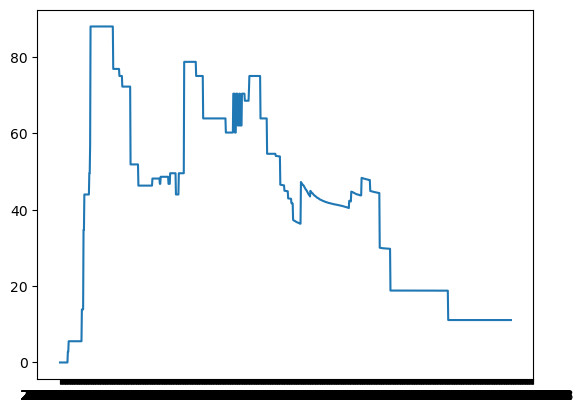

In [271]:
plt.plot(covid_stringency['date'], covid_stringency['stringency_index'])

In [272]:
# Joining both tables

df_work_try["YMD"] = df_work_try["date"].dt.date # Creating the appropriate column in our df_work
covid_stringency['date'] = pd.to_datetime(covid_stringency['date']).dt.date

df_work_try = pd.merge(df_work_try, covid_stringency, left_on='YMD', right_on='date').drop(columns=['iso_code', 'date_y'])

In [262]:
Y_work_test = df_work_try["log_bike_count"]
X_work_test = df_work_try.drop(columns=["log_bike_count"])

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name","site_name", "month", "day", "weekday", "hour", "IsHoliday"]

numerical_cols = ['stringency_index']

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        ("num_cols", "passthrough", numerical_cols)
    ]
)

regressor = Ridge()

pipe = make_pipeline(preprocessor, regressor)
pipe.fit(X_work_test, Y_work_test)

print(
    f"Train set, RMSE={mean_squared_error(Y_work_test, pipe.predict(X_work_test), squared=False)}"
)
"""
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"
)

"""



Train set, RMSE=0.8006769781908435


'\nprint(\n    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False)}"\n)\n\n'

In [250]:
pd.to_datetime(covid_stringency['date']).dt.date[0]

datetime.date(2020, 1, 3)

### NOTES
- bien reset l'index
- Remove 'year' as already included in the month, pareil pour site_name inclut dans site_id?
- Bizarre que latitude / longitude affecte absolument pas
- essayé de rendre cyclique weekday et hour: pas très concluant